In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import spacy

### Import

In [7]:
graph_df=pd.read_csv("../Data/graph_df.csv")

In [8]:
graph_df.head()

,Wikipedia movie ID,char A,action,char B,combined_action
0,31186339,Peeta,"['reveal', 'love', 'for']",Katniss,reveal love for
1,31186339,Katniss,['discover'],Peeta,discover
2,31186339,Rue,['call'],Katniss,call
3,31186339,Katniss,['find'],Rue,find
4,31186339,Katniss,"['comfort', 'the', 'dying']",Rue,comfort the dying


# Preprocessing

In [9]:
#graph_df['action']=graph_df['action'].apply(lambda x : ast.literal_eval(x) if  pd.notnull(x) else np.nan)

In [10]:
# this is the column for converting the action to a string
#graph_df['action_string'] =graph_df['action'].apply(lambda x: ' '.join(x))

In [11]:
#graph_df.head()

In [14]:
actions_string=graph_df['combined_action'].values
len(actions_string)

126309

In [16]:
# unique values
actions_string=set(actions_string)
actions_string=list(actions_string)
len(actions_string)

36264

Create test of 10000 sentences:

In [21]:
test=actions_string[:20000]

# Sentiment analysis

In [22]:
from transformers import pipeline
import torch

In [23]:
classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", return_all_scores=True)


/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [24]:
labels = ["action",
    "admiration", "amusement", "anger", "approval", "caring", "confusion", "curiosity",
    "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude",
    "joy", "love", "nervousness", "optimism", "pride", "remorse",
    "sadness", "surprise", "neutral"
]

In [25]:
from tqdm import tqdm  # Import tqdm

# Create an empty DataFrame to store the results
#columns = ['Action', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df_results = pd.DataFrame(columns=labels)

# Create a tqdm progress bar for the loop
with tqdm(total=len(test)) as pbar:
    # Iterate through each verb and classify its emotion
    for item in test:
        # Classify emotion for the verb
        emotion_scores = classifier(item)[0]

        # Create a dictionary with the results
        result_dict = {'action': item}
        result_dict.update({emotion['label']: emotion['score'] for emotion in emotion_scores})
        # Append the results to the DataFrame
        df_results.loc[len(df_results)] = result_dict

        # Update the progress bar
        pbar.update(1)

# Display the final DataFrame
df_results.head()


  1%|▏                                      | 121/20000 [00:04<13:33, 24.43it/s]


KeyboardInterrupt: 

# Clustering with sentiment analysis

### Elbow method

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

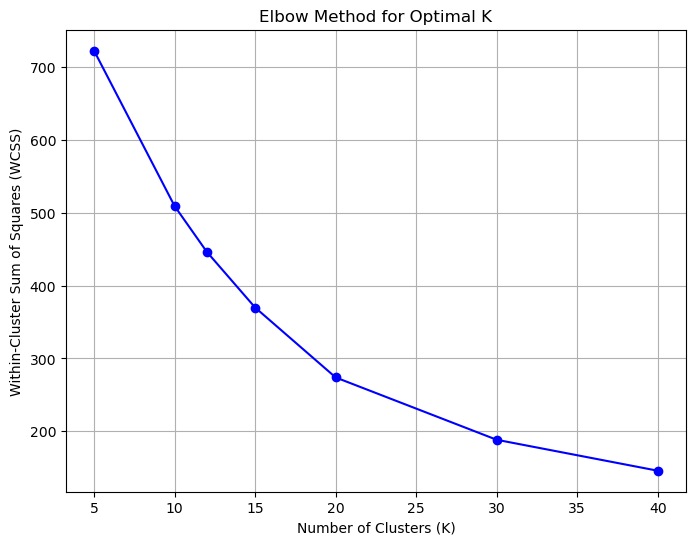

In [23]:
import matplotlib.pyplot as plt

# Select columns for clustering
#columns_for_clustering = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
columns_for_clustering=labels[1:]
data_for_clustering = df_results[columns_for_clustering]

# Define a range of values for K
k_values = [5, 10, 12, 15, 20, 30, 40]

# Create an empty list to store the WCSS values
wcss_values = []

# Calculate WCSS for each value of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_for_clustering)
    wcss = kmeans.inertia_
    wcss_values.append(wcss)

# Plot the WCSS values
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

### K-means clustering

In [42]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select columns for clustering
#columns_for_clustering = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
columns_for_clustering=labels[1:]
data_for_clustering = df_results[columns_for_clustering]

# Choose the number of clusters (K)
k = 15

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
df_results['cluster'] = kmeans.fit_predict(data_for_clustering)

/Users/davide/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
df_results.head(10)

,action,admiration,amusement,anger,approval,caring,confusion,curiosity,desire,disappointment,...,optimism,pride,remorse,sadness,surprise,neutral,cluster,action_filtered,words,filtered_words
0,see ulterior motive of,0.002984,0.002432,0.002950,0.011367,0.001034,0.003914,0.002425,0.001025,0.002951,...,0.001742,0.000353,0.000372,0.002325,0.001357,0.964864,0,see ulterior motive,"[see, ulterior, motive]","[see, ulterior, motive]"
1,"end their arrangement , which upsets",0.002665,0.001170,0.003200,0.013834,0.002100,0.003224,0.001739,0.001033,0.504667,...,0.005907,0.000750,0.005323,0.079193,0.004373,0.477941,2,"end arrangement , upsets","[end, arrangement, ,, upsets]","[end, arrangement, upsets]"
2,wish would have been with,0.002914,0.004003,0.004604,0.007798,0.004280,0.003329,0.005477,0.781913,0.020718,...,0.035870,0.000673,0.004269,0.011338,0.002535,0.167864,10,wish would,"[wish, would]","[wish, would]"
3,overwhelm,0.003485,0.001389,0.005701,0.009450,0.001061,0.001101,0.000734,0.001039,0.007361,...,0.001470,0.000398,0.000353,0.003299,0.001152,0.946947,0,overwhelm,[overwhelm],[overwhelm]
4,reveal that is only working for,0.002527,0.001717,0.002295,0.014760,0.001021,0.002075,0.001162,0.001067,0.004349,...,0.002184,0.000315,0.000411,0.002641,0.000854,0.967039,0,reveal working,"[reveal, working]","[reveal, working]"
5,make the final arrangements for the ball drop ...,0.001927,0.001147,0.001452,0.018304,0.001762,0.002601,0.001247,0.001690,0.002690,...,0.003687,0.000276,0.000402,0.001759,0.000521,0.961186,0,make final arrangements ball drop help friend,"[make, final, arrangements, ball, drop, help, ...","[make, final, arrangements, ball, drop, help, ..."
6,reveal a letter from,0.002327,0.002183,0.004041,0.009130,0.001312,0.002864,0.002083,0.001455,0.003674,...,0.001973,0.000323,0.000476,0.003088,0.001213,0.968602,0,reveal letter,"[reveal, letter]","[reveal, letter]"
7,lead the life of the perfect wife and mother —...,0.085444,0.000428,0.000800,0.267644,0.030516,0.000804,0.000642,0.005028,0.001806,...,0.013459,0.006112,0.000526,0.002019,0.000410,0.619011,2,lead life perfect wife mother — life one point...,"[lead, life, perfect, wife, mother, —, life, o...","[lead, life, perfect, wife, mother, life, one,..."
8,catch an angry,0.001214,0.004276,0.061206,0.005649,0.003465,0.002390,0.003857,0.001339,0.002312,...,0.002387,0.000276,0.000310,0.002321,0.000926,0.896212,0,catch angry,"[catch, angry]","[catch, angry]"
9,experience a surreal dream in which,0.002379,0.026927,0.001621,0.010408,0.003671,0.002155,0.006500,0.017682,0.003022,...,0.013868,0.001574,0.000741,0.005997,0.028259,0.396776,14,experience surreal dream,"[experience, surreal, dream]","[experience, surreal, dream]"


## Inspect better the clusters with most frequent words & TF-IDF

In [44]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  # Import word_tokenize

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a sentence
def remove_stopwords(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

# Assuming df is your DataFrame and 'sentence' is the column with sentences
df_results['action_filtered'] = df_results['action'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davide/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
from collections import Counter
import re

df_results['words'] = df_results['action_filtered'].apply(lambda x: x.split())

# Function to clean words in each sentence
def clean_words(words_list):
    # Use regular expression to filter out words with non-letter characters
    cleaned_list = [word for word in words_list if word and re.match("^[a-zA-Z]+$", word)]
    return cleaned_list

# Apply the cleaning function to the 'words' column
df_results['filtered_words'] = df_results['words'].apply(clean_words)

# Calculate term frequencies for each cluster
cluster_word_freq = {}
for cluster_id in df_results['cluster'].unique():
    words_in_cluster = [word for sublist in df_results[df_results['cluster'] == cluster_id]['filtered_words'].tolist() for word in sublist]
    cluster_word_freq[cluster_id] = Counter(words_in_cluster)


In [46]:
# Create a corpus for each cluster by concatenating all sentences in the cluster
corpus_per_cluster = []
for cluster_id in range(k):  # Assuming there are 10 clusters
    # Get all sentences in this cluster
    sentences_in_cluster = df_results[df_results['cluster'] == cluster_id]['action_filtered']

    # Concatenate them into one string
    concatenated_sentences = ' '.join(sentences_in_cluster)
    
    corpus_per_cluster.append(concatenated_sentences)


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to the corpus
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus_per_cluster)
tfidf_feature_names = vectorizer.get_feature_names_out()

# Extract top unique terms per cluster based on TF-IDF scores
top_n = 30  # Number of top terms to extract for each cluster
top_unique_terms_per_cluster = {i: sorted(zip(tfidf_feature_names, tfidf_matrix.toarray()[i]), key=lambda x: x[1], reverse=True)[:top_n] for i in range(k)}


In [48]:
# TOP TERMS FOR EACH CLUSTER

# Define the number of top terms to extract for each cluster
top_n = 20

# Initialize dictionaries to store frequent and unique words for each cluster
frequent_words_per_cluster = {}
unique_words_per_cluster = {}

for cluster_id in range(k):  # Assuming there are 10 clusters
    # Store the most common terms in this cluster
    frequent_words_per_cluster[cluster_id] = [term for term, freq in cluster_word_freq[cluster_id].most_common(top_n)]

    # Store top unique terms based on TF-IDF scores
    unique_words_per_cluster[cluster_id] = [term for term, score in top_unique_terms_per_cluster[cluster_id]]

# Print the list of frequent and unique words for each cluster
for cluster_id in range(k):
    freq_words = frequent_words_per_cluster[cluster_id]
    unique_words = unique_words_per_cluster[cluster_id]
    print(f"Cluster {cluster_id}")
    print(f"Frequent Words: {', '.join(freq_words)}\n")
    print(f"Unique Words: {', '.join(unique_words)}\n\n\n")


Cluster 0
Frequent Words: find, meet, reveal, make, say, named, see, take, get, tell, one, give, friend, call, man, old, learn, visit, know, ask

Unique Words: find, meet, reveal, named, make, see, say, take, give, tell, get, one, friend, dr, learn, ask, visit, call, suggest, discover, man, encounter, confess, father, old, mr, marry, show, send, know



Cluster 1
Frequent Words: surprise, believe, visit, surprised, find, shocked, make, wonder, shocking, unexpected, pay, killed, unexpectedly, get, child, husband, news, meet, muse, much

Unique Words: surprise, surprised, shocked, believe, visit, shocking, unexpectedly, wonder, unexpected, conclusion, surprises, surprisingly, find, pay, make, appearance, muse, killed, child, news, watch, get, arbitrator, astonished, burrow, comprise, diplomatic, disbelieve, discoveries, dolphins



Cluster 2
Frequent Words: realize, discover, learn, believe, find, make, admit, love, one, father, new, life, feel, kill, announce, help, wife, named, killed,

In [616]:
# CODE TO COMBINE UNIQUE AND FREQUENT WORDS for a future wordcloud

'''# Define the balance between frequent and unique terms
balance_ratio = 0.5  # Adjust as needed
top_n = 10  # Number of top terms to extract for each cluster

word_cloud_data = {}
for cluster_id in range(10):
    # Get the most common terms in this cluster
    freq_terms = [term for term, freq in cluster_word_freq[cluster_id].most_common(top_n)]

    # Get top unique terms based on TF-IDF scores
    unique_terms = [term for term, score in top_unique_terms_per_cluster[cluster_id]]

    # Combine the lists while maintaining the balance
    combined_terms = freq_terms[:int(top_n * balance_ratio)] + unique_terms[:int(top_n * (1 - balance_ratio))]
    word_cloud_data[cluster_id] = ' '.join(combined_terms)


### Look at individual sentences

In [1]:
cluster_sentences = df_results.groupby('cluster')['action']
cluster_counts = df_results.groupby('cluster').size().reset_index(name='count')
print(cluster_counts)


NameError: name 'df_results' is not defined

### Distribution of clusters

In [99]:
# Assuming cluster_counts is your DataFrame with 'cluster' and 'count' columns

# Calculate the total count of sentences
total_count = cluster_counts['count'].sum()

# Calculate and print the percentage for each cluster
cluster_counts['percentage'] = (cluster_counts['count'] / total_count) * 100
print(cluster_counts)


    cluster  count  percentage
0         0  14389      71.945
1         1     66       0.330
2         2    947       4.735
3         3    305       1.525
4         4    188       0.940
5         5    164       0.820
6         6    280       1.400
7         7   2284      11.420
8         8    121       0.605
9         9    138       0.690
10       10     87       0.435
11       11     74       0.370
12       12     46       0.230
13       13    137       0.685
14       14    774       3.870


In [97]:
# Specify the cluster you want to print
cluster_to_print = 2

# Filter the DataFrame for the specific cluster
cluster_data = df_results[df_results['cluster'] == cluster_to_print]['action']

# Check if the cluster has any data
if not cluster_data.empty:
    # Print all sentences for the specific cluster
    sentences = cluster_data.tolist()
    print(f"All sentences for Cluster {cluster_to_print}:\n")
    for sentence in sentences:
        print(sentence)
else:
    print(f"No data found for Cluster {cluster_to_print}")


All sentences for Cluster 2:

end their arrangement , which upsets
lead the life of the perfect wife and mother — a life which at one point prompts one of her daughters to ask
realize she must find a way to turn the tables on Star , if she wants to get
acknowledge the apparent wisdom of
lose track of 's invisible car that has the anti - serum to restore
develop a crush on named
make unprovoked , threatening remarks toward
believe the hope for humanity lies within
encourage growing trust in him
realize that behind hatred of
realize that apprentice
realize wants to be with
lose control and decks graduate student
respond This is not an emotional issue , Mrs.
confide that has just been released from a hospital after suffering a nervous breakdown
realize that with her new perm , Sonoko looks like
witness a disturbing encounter between
notice that the area and the community is being controlled by notorious gangster ,
notice that has been using again and helps her
feel that should not tell
ma